In [0]:
# Mount G Drive files

from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/Capstone/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# bring in Kaggle API
# need to pull this file from Kaggle based on your user ID for the site

from google.colab import files

api = files.upload() 

Saving kaggle.json to kaggle.json


In [0]:
# load Kaggle

!pip install -q Kaggle

In [0]:
# make a directory to save the .json file

! mkdir =p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [0]:
# load Kaggle data

! kaggle datasets download -d nih-chest-xrays/sample

100% 4.19G/4.20G [01:37<00:00, 34.5MB/s]
100% 4.20G/4.20G [01:37<00:00, 46.2MB/s]


In [0]:
# save files in .zip folder to G Drive

!unzip -q sample.zip -d image_path

In [0]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, Xception, MobileNet, NASNetLarge, ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse
import cv2
import os

sns.set_style('whitegrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# load the label data

labels_df = pd.read_csv('/content/drive/My Drive/Capstone/sample_labels.csv', low_memory=False)

In [0]:
# create Y/N field for conditions
# the image either does or doesn't have one present

def conditions(x):
  if 'No Finding' in x:
    return 'N'
  return 'Y'

labels_df['HasCondition'] = labels_df['Finding Labels'].map(conditions)

In [0]:
# one hot encode results

labels_df_cat = pd.concat([labels_df.drop(['HasCondition'], axis=1), pd.get_dummies(labels_df['HasCondition'], prefix='Condition')], axis=1)

In [0]:
# add one hot encoding for labels
# used to include multiple conditions

conditions = ['No Finding','Infiltration','Atelectasis','Effusion','Nodule','Pneumothorax','Mass','Consolidation','Pleural_Thickening','Cardiomegaly','Emphysema','Fibrosis','Edema','Pneumonia','Hernia']

for i in conditions :
    labels_df[i] = labels_df['Finding Labels'].apply(lambda x: 1 if i in x else 0)

In [0]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,HasCondition,No Finding,Infiltration,Atelectasis,Effusion,Nodule,Pneumothorax,Mass,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Fibrosis,Edema,Pneumonia,Hernia
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,Y,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,Y,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,N,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,Y,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,Y,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [0]:
# load images from directory
# save them as a list

img_path = '/content/image_path/sample/images/'
image_shape = (128,128)
scans = []
img_id = []

for file in os.listdir(img_path):
  picture = load_img(img_path+file, target_size=image_shape)
  picture = img_to_array(picture)
  scans.append(picture)
  img_id.append(file)

In [0]:
# combine image IDs from download with their labels

img_id_df = pd.DataFrame(img_id, columns = ['IMG_ID'])
image_labels = labels_df[['Image Index','No Finding','Infiltration','Atelectasis','Effusion','Nodule','Pneumothorax','Mass','Consolidation','Pleural_Thickening','Cardiomegaly','Emphysema','Fibrosis','Edema','Pneumonia','Hernia']]

img_id_df = pd.merge(img_id_df, image_labels, how = 'left', left_on = ['IMG_ID'], right_on = ['Image Index'])

In [0]:
# create table with just labels for model input

labels = img_id_df[['No Finding','Infiltration','Atelectasis','Effusion','Nodule','Pneumothorax','Mass','Consolidation','Pleural_Thickening','Cardiomegaly','Emphysema','Fibrosis','Edema','Pneumonia','Hernia']]

These blocks are the steps that stage the data for the model inputs

In [0]:
# set up data for the model

seed = 42

X = np.array(scans)/255.0
y = np.array(labels)

# this is for original data
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = seed)

#configure data using image data generator

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 15,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

test_data_gen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 15,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)


In [0]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
def model_picker(name):
#
#  """Function allows the choice of any pretrained model contained within the 
#  Keras architecture but without the top classification layers so only the 
#  bottleneck features are retained.
#
#  Args: 
#      Model name (str): The name of the desired model
#
#  Returns: 
#      Selected model
#  """
#
  if (name == 'VGG16'):
        model = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  elif (name == 'VGG19'):
        model = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  elif (name == 'MobileNet'):
        model = MobileNet(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  elif (name == 'InceptionV3'):
        model = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  elif (name == 'ResNet50'):
        model = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  elif (name == 'Xception'):
        model = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
        
  else:
        print("Specified model not available")
  return model

[INFO] compiling model...VGG16
[INFO] training head...
Epoch 1/25
44/44 [==============================] - 24s 556ms/step - loss: 0.3519 - accuracy: 0.3960 - val_loss: 0.2305 - val_accuracy: 0.5098
Epoch 2/25
44/44 [==============================] - 24s 548ms/step - loss: 0.2454 - accuracy: 0.4991 - val_loss: 0.2240 - val_accuracy: 0.5098
Epoch 3/25
44/44 [==============================] - 24s 551ms/step - loss: 0.2338 - accuracy: 0.5287 - val_loss: 0.2204 - val_accuracy: 0.5098
Epoch 4/25
44/44 [==============================] - 24s 553ms/step - loss: 0.2242 - accuracy: 0.5420 - val_loss: 0.2195 - val_accuracy: 0.5098
Epoch 5/25
44/44 [==============================] - 24s 551ms/step - loss: 0.2208 - accuracy: 0.5477 - val_loss: 0.2184 - val_accuracy: 0.5098
Epoch 6/25
44/44 [==============================] - 24s 548ms/step - loss: 0.2184 - accuracy: 0.5497 - val_loss: 0.2166 - val_accuracy: 0.5098
Epoch 7/25
44/44 [==============================] - 24s 554ms/step - loss: 0.2164 - acc

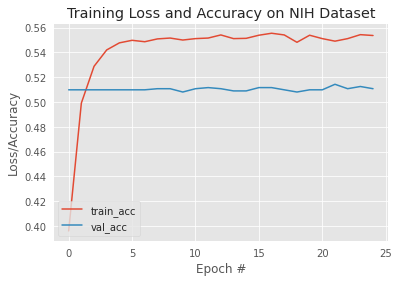

[INFO] saving NIH detector model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: covid19_model_VGG16/assets
80142336/80134624 [==============================] - 1s 0us/step
[INFO] compiling model...VGG19
[INFO] training head...
Epoch 1/25
44/44 [==============================] - 26s 590ms/step - loss: 0.3511 - accuracy: 0.3857 - val_loss: 0.2300 - val_accuracy: 0.5098
Epoch 2/25
44/44 [==============================] - 26s 586ms/step - loss: 0.2456 - accuracy: 0.5009 - val_loss: 0.2244 - val_accuracy: 0.5098
Epoch 3/25
44/44 [==============================] - 26s 587ms/step - loss: 0.2331 - accuracy: 0.5370 - val_loss: 0.2226 - val_accuracy: 0.5098
Epoch 4/25
44/44 [==============================] - 26s 589ms/step - loss: 0.2282 - accuracy: 0.5413 - val_loss: 0.2221 - val_accuracy: 0.5098
Epoch 5/25
44/44 [==============================] - 26s 590ms/step - loss: 0.2256 - accuracy: 0.5488 - val_loss: 0.2215 - val_acc

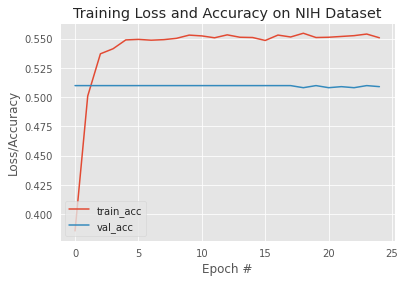

[INFO] saving NIH detector model...
INFO:tensorflow:Assets written to: covid19_model_VGG19/assets


In [0]:
model = ['VGG16','VGG19']
#all_models = ['VGG16','VGG19','MobileNet','InceptionV3','ResNet50','Xception']

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

for model_str in model:
    
#    model = model_picker(model)
    
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    
    baseModel = model_picker(model_str)
    
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(15, activation="sigmoid")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
        
    # compile our model
    INIT_LR = 1e-3
    EPOCHS = 25
    BS = 100
    
    print("[INFO] compiling model..."+model_str)
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    # train the head of the network
    print("[INFO] training head...")
    H = model.fit_generator(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS,
        verbose = 1)
    
    # make predictions on the testing set
    print("[INFO] evaluating network...")
    predIdxs = model.predict(testX, batch_size=BS)
    
    
    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    predIdxs = np.argmax(predIdxs, axis=1)
    
    # show a nicely formatted classification report
    #print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))
    
    
    # compute the confusion matrix and and use it to derive the raw
    # accuracy, sensitivity, and specificity
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    
    # show the confusion matrix, accuracy, sensitivity, and specificity
    print(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    
    # plot the training loss and accuracy
    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    #plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    #plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on NIH Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('plot')
    plt.show()
    
    # serialize the model to disk
    print("[INFO] saving NIH detector model...")
    model.save('covid19_model_'+model_str)